In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import os

# Shutil is a recursive tool to delete file paths
# Note: Only needed if you plan to overwrite existing filepaths
import shutil

In [2]:
os.getcwd()

'C:\\Users\\admin\\Documents\\__SU22\\DOETrucksMeeting\\Scott\\OLS_6_28'

# Function: generateData
### Performs OLS on every edge and saves a, b into csv and pickle files 

> (bool) freight : Freight mode calculation on or off  
(str) dataSourcePath : Source data file path (.xlsx)  
(str) saveFolderName : Name of the folder to save the data (non-existing)

## Note:  -1 is a dummy value (for self-loops and array padding)

In [30]:
def generateData (dataSourcePath = 'Batch_Div27_2021_03_months_Conv_BE_RH_Base_Edges_Crr_Std_Results_metrics.xlsx', \
                  saveFolderName = "OLS_Data",\
                  freight = False,\
                  preprocessing = True,\
                 ):
    parent_dir = os.getcwd()
    savePath = os.path.join(parent_dir, saveFolderName)
    
    # If the old date folder already exists, remove the folder
    print('Checking for prexisting data')
    if os.path.exists(savePath):
        shutil.rmtree(savePath)
        print('Removed ', savePath)

    if os.path.exists(dataSourcePath[:-5] + "_node_label.xlsx"):
        os.remove(dataSourcePath[:-5] + "_node_label.xlsx")
        print('Removed ', dataSourcePath[:-5] + "_node_label.xlsx")

    print('Removed all existing previous Data!\n')
    os.makedirs(savePath)
    
    # Load and trim Data
    print('Loading Data...')
    df = pd.read_excel(dataSourcePath, index_col=None, usecols=['Vehicle Model-none',\
                          'Battery Energy Consumption per Mile-kWh/mi',\
                          'Vehicle Static Mass-lbm',\
#                           'Cycle Source-none',\
                          'Average Total Speed-mph',\
                          'Fuel Economy-mpg',\
                          'Cycle Name-none',\
                          'Cargo Mass-lbm'])
    # Doing conversions
    df['Fuel Economy-mpg'] = df['Fuel Economy-mpg']*1.60934
    df['Cargo Mass-lbm'] = df['Cargo Mass-lbm']*0.453592
    df['Vehicle Static Mass-lbm'] = df['Vehicle Static Mass-lbm']*0.453592
    df['Battery Energy Consumption per Mile-kWh/mi'] = df['Battery Energy Consumption per Mile-kWh/mi']/1.60934
    df['Average Total Speed-mph'] = df['Average Total Speed-mph']*1.60934
    df = df.rename(columns={'Fuel Economy-mpg': 'Fuel Economy-km/g', 'Cargo Mass-lbm' : 'Cargo Mass-kg',\
                            'Vehicle Static Mass-lbm' : 'Vehicle Static Mass-kg', \
                            'Battery Energy Consumption per Mile-kWh/mi' : 'Battery Energy Consumption per Mile-kWh/km',\
                            'Average Total Speed-mph' : 'Average Total Speed-km/h'
                           })
    
    print('Done Loading Data!\n')
    
    if preprocessing == True:
        print('Preprocessing Data...')
        nodeOrder = pd.read_excel('0623_hetero\\Batch_Div27_2021_03_months_Conv_BE_RH_Base_Edges_Crr_Std_Results_metrics (1).xlsx', \
                          sheet_name = "RouteMatching", \
                          index_col=None, usecols= ['Name3', 'Start Node Name', 'End Node Name', 'Start Node', 'End Node'])

        def checking(x):
            for idx, y in enumerate(nodeOrder['Name3'].values):
                thres = 5
                y = y.replace('\'', '')
                a = x.split('_')[1:5]
                b = y.split('_')[1:5]

                a = [[int(j) for j in i.split('p')] for i in a]
                b = [[int(j) for j in i.split('p')] for i in b]

                # Check if the minutes are within +- 2 
                c = [((a[i][0] == b[i][0]) and (a[i][1] >= (b[i][1]-thres)) and (a[i][1] <= (b[i][1]+thres))) for i in range(np.size(a, 0))]

                # If all matches
                if (all(c)):
                    # get the start, and end node
                    i = nodeOrder['Start Node'].iloc[[idx]].values[0]
                    j = nodeOrder['End Node'].iloc[[idx]].values[0]
                    return (i, j)
            return np.nan
        
#         df['Cycle Name-none'] = df['Cycle Name-none'].apply(checking)
#         df[['i', 'j']] = pd.DataFrame(df['Cycle Name-none'].tolist(), index=df.index)
#         df.drop('Cycle Name-none', inplace=True, axis=1)
        
        # Saving the sheet with the nodes labelled
        temp = df.columns.get_loc('Cycle Name-none')
        df['temp'] = df['Cycle Name-none'].apply(checking)

        a = pd.DataFrame(df['temp'].tolist(), index=df.index)
        df.insert(temp + 1, 'start_node', a[0])
        df.insert(temp + 2, 'end_node', a[1])
        df.drop('temp', inplace=True, axis=1)
        df.to_excel(dataSourcePath[:-5] + "_node_label.xlsx")
        df = df.rename(columns={'start_node': 'i', 'end_node' : 'j'})

        # Return the total number of nodes here
        numNodes = max(df['i'].unique().max(), df['j'].unique().max())
        print('Labelled version of the sheet saved as: ', dataSourcePath[:-5] + "_node_label.xlsx")
        
    else:

        # Function to look for the number of nodes from a list of strings in the source file
        def findNumNodes(sentence_arr):
            running_max = 1
            length = len(sentence_arr)
            i_val = np.full(length, 0)
            j_val = np.full(length, 0)
            for index, sentence in enumerate(sentence_arr):

                # Split the string, and get the corresponding node values
                temp = sentence.lower().split('div')[1].split('_raw')[0].split('_')
                j = temp[-1]
                i = temp[-2]
                j = int(''.join([x for x in j if x.isdigit()]))
                i = int(''.join([x for x in i if x.isdigit()]))
                running_max = max(i, j, running_max)
                i_val[index], j_val[index] = i, j
            return running_max, i_val, j_val

        # Adding "i" and "j" columns for lookup convenience later in code
        numNodes, i_val, j_val = findNumNodes(df["Cycle Source-none"].values)
        df.drop("Cycle Source-none", axis = 'columns')
        df['i'], df['j'] = i_val, j_val
    
    print('Done Preprocessing Data!\n')
    
    # Setup for csv files index and column labels
    cols = ["i_" + str(i) for i in range(1, numNodes+1)]
    rows = ["j_" + str(i) for i in range(1, numNodes+1)]
    
    # Getting information from the dataframe
    vehicleTypes = pd.Series(df['Vehicle Model-none'].values).unique()
                   
    # Loop for Vehicle Types (k)
    for v in vehicleTypes:
        # check if the vehicle is conv or bev
        conv = (v.find('conv') != -1)
        b_list = np.array([])
        workFrame = df[df["Vehicle Model-none"] == v]
        newFrame = pd.DataFrame(columns = cols, index = rows)
        print('\nFor Vehiecle: ', v)
        print('Detected type: ', ('conv' if conv else 'bev'))
        
        if freight == True:
            x_val = 'Cargo Mass-kg'
        else:
            x_val = 'Vehicle Static Mass-kg'    
        if conv == True:
            y_val = 'Fuel Economy-km/g'
        else:
            y_val = 'Battery Energy Consumption per Mile-kWh/km'
        
        print('LR Using:', '\nx_val = ', x_val, '\ny_val = ', y_val, '\n')
        
        # Iterate over node values i, j, and assign constants a, b, into "newFrame"
        for i in range(1, numNodes + 1):
            for j in range(1, numNodes + 1):
                data = workFrame.loc[((workFrame['i'] == i) & (workFrame['j'] == j))]
                
                # edge case if i = j or data Doesn't exist
                if i == j :
                    newFrame.iat[j - 1, i - 1] = -1
                    continue
#                 print('For i = ', i, ' , j = ', j, ': size: ', data.size)
                if data.size == 0:
                    newFrame.iat[j - 1, i - 1] = 0
                    continue

                # Doing linear regression here
                X = (data.loc[:, [x_val]]).values.reshape(-1, 1)
                Y = (data.loc[:, [y_val]]).values.reshape(-1, 1)
                LR = LinearRegression()  # create object for the class
                LR.fit(X, Y)  # perform linear regression
                
#                 x_label = x_val
#                 y_label = y_val
#                 Y_pred = LR.predict(X)  # make predictions

#                 # Data Visualization
#                 plt.figure()
#                 plt.scatter(X, Y)
#                 plt.plot(X, Y_pred, color='red')
#                 plt.xlabel(x_label)
#                 plt.ylabel(y_label)
                
                # Assigning the calculated a, b params
                newFrame.iat[j - 1, i - 1] = (LR.coef_.item(0), LR.intercept_.item(0))
                b = LR.intercept_.item(0)/ np.average(np.square(data.loc[:, ['Average Total Speed-km/h']]).values)
                b_list = np.append(b_list, b)
                print(' Coeffs: a = ', LR.coef_.item(0), ', bv^2 = ', LR.intercept_.item(0),'b = ', b, ')', )
        
        # Visualize histogram of the bs
        print('# b-values: ', b_list.size)
        plt.hist(b_list, bins=25)
        plt.show() 
    
        # Create the filePath
        tempPath2 = os.path.join(savePath, v + ".csv")
        tempPath3 = os.path.join(savePath, v + ".pkl")
        newFrame.to_csv(tempPath2)
        newFrame.to_pickle(tempPath3)
#         break
#     break

Checking for prexisting data
Removed  C:\Users\admin\Documents\__SU22\DOETrucksMeeting\Scott\OLS_6_28\OLS_Data
Removed  0623_hetero\Batch_Div27_Rep_Day_Class_8_Compiled_Results_metrics_node_label.xlsx
Removed all existing previous Data!

Loading Data...
Done Loading Data!

Preprocessing Data...
Labelled version of the sheet saved as:  0623_hetero\Batch_Div27_Rep_Day_Class_8_Compiled_Results_metrics_node_label.xlsx
Done Preprocessing Data!


For Vehiecle:  class8_conv_2021_low_sleeper_longhaul_FU19
Detected type:  conv
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Fuel Economy-km/g 

 Coeffs: a =  -0.00027969106145396316 , bv^2 =  17.606188473754706 b =  0.019935864185686606 )
 Coeffs: a =  -0.0003209696040243143 , bv^2 =  21.198893482180804 b =  0.00856855618914001 )
 Coeffs: a =  -0.0002778650229537594 , bv^2 =  21.984380590341342 b =  0.004068686843967362 )
 Coeffs: a =  -0.00028269023497571406 , bv^2 =  21.62545766486003 b =  0.004274400036069151 )
 Coeffs: a =  -0.0002331743

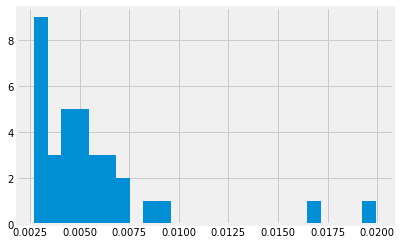


For Vehiecle:  class8_mild48v_2021_low_sleeper_longhaul_FU19
Detected type:  bev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Battery Energy Consumption per Mile-kWh/km 

 Coeffs: a =  -4.0601277373824344e-07 , bv^2 =  0.04814225920279912 b =  5.308756514208309e-05 )
 Coeffs: a =  -1.4632630879493796e-08 , bv^2 =  0.0065546459959831055 b =  2.607774078779678e-06 )
 Coeffs: a =  -2.3673862968056793e-08 , bv^2 =  0.003419948853792947 b =  6.282526954806507e-07 )
 Coeffs: a =  3.124967602369531e-09 , bv^2 =  0.0034510198438299274 b =  6.755775409846388e-07 )
 Coeffs: a =  -1.765059264811222e-08 , bv^2 =  0.003296421464787461 b =  4.77409316232379e-07 )
 Coeffs: a =  -8.677376241550516e-08 , bv^2 =  0.006577080697596608 b =  2.5005836031237877e-06 )
 Coeffs: a =  -1.212495269938336e-07 , bv^2 =  0.004962478437505987 b =  1.4436887286053217e-06 )
 Coeffs: a =  -2.2009228093319326e-08 , bv^2 =  0.0028973814912849685 b =  7.972033573228633e-07 )
 Coeffs: a =  -2.2611079090067718e-08 

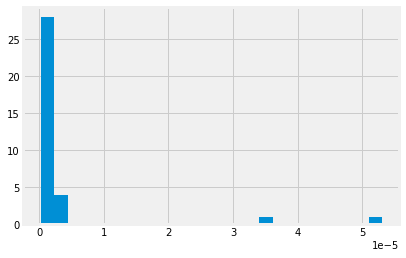


For Vehiecle:  class8_erev_2021_low_sleeper_longhaul_FU19
Detected type:  bev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Battery Energy Consumption per Mile-kWh/km 

 Coeffs: a =  1.593264832788191e-05 , bv^2 =  0.5025298229742852 b =  0.0005505028124327908 )
 Coeffs: a =  9.828392083016639e-06 , bv^2 =  0.49564176628541884 b =  0.00019661441343808844 )
 Coeffs: a =  4.549150456525324e-06 , bv^2 =  0.483320067136402 b =  8.866324883078511e-05 )
 Coeffs: a =  9.093815717438992e-06 , bv^2 =  0.4861131652348799 b =  9.499364679641152e-05 )
 Coeffs: a =  3.4433532340401615e-06 , bv^2 =  0.5157967253384865 b =  7.463430520495807e-05 )
 Coeffs: a =  1.020514143441367e-05 , bv^2 =  0.5600413611852677 b =  0.00021202523367147967 )
 Coeffs: a =  8.923006896708835e-06 , bv^2 =  0.5094878550675496 b =  0.00014785790664161456 )
 Coeffs: a =  2.921055784728116e-06 , bv^2 =  0.4846964029549155 b =  0.0001329044333916118 )
 Coeffs: a =  5.421913784473893e-06 , bv^2 =  0.5055581157129944 b 

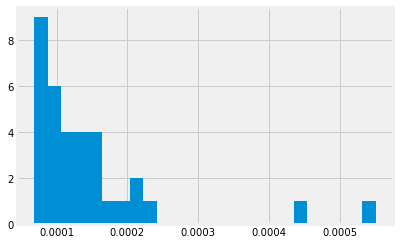


For Vehiecle:  class8_bev_2021_low_sleeper_longhaul_FU19
Detected type:  bev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Battery Energy Consumption per Mile-kWh/km 

 Coeffs: a =  2.677366546242746e-05 , bv^2 =  0.5361017803620698 b =  0.0005856787728312635 )
 Coeffs: a =  2.3256682291568793e-05 , bv^2 =  0.5355544542949666 b =  0.0002121321629448855 )
 Coeffs: a =  1.798240501696572e-05 , bv^2 =  0.6601836637056041 b =  0.00012103180333300832 )
 Coeffs: a =  1.9093458410169004e-05 , bv^2 =  0.6566214067113114 b =  0.00012820750175719647 )
 Coeffs: a =  1.7916341205544978e-05 , bv^2 =  0.7768671986330342 b =  0.00011236016411756116 )
 Coeffs: a =  2.0441750032853404e-05 , bv^2 =  0.7193276841820222 b =  0.00027177772103746835 )
 Coeffs: a =  2.1587196813076783e-05 , bv^2 =  0.602139565007366 b =  0.00017453055955031043 )
 Coeffs: a =  1.8991477748144635e-05 , bv^2 =  0.711301696897397 b =  0.00019482357214576656 )
 Coeffs: a =  1.7886651747119433e-05 , bv^2 =  0.6993428285159

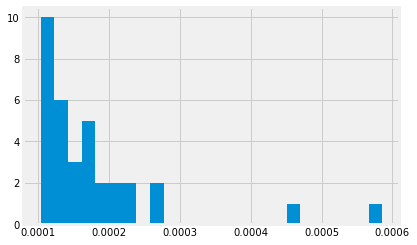


For Vehiecle:  class8_fchev_2021_low_sleeper_longhaul_FU19
Detected type:  bev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Battery Energy Consumption per Mile-kWh/km 

 Coeffs: a =  6.418403982827037e-06 , bv^2 =  -0.19764133645258858 b =  -0.0002165795833502117 )
 Coeffs: a =  1.7962732046709605e-06 , bv^2 =  -0.05748018644038446 b =  -2.2808908323929102e-05 )
 Coeffs: a =  7.648936718906786e-07 , bv^2 =  -0.019456438864371504 b =  -3.5695914137795814e-06 )
 Coeffs: a =  1.5619929635705282e-06 , bv^2 =  -0.04295984521763177 b =  -8.400275442267308e-06 )
 Coeffs: a =  3.037476469779002e-07 , bv^2 =  -0.01170927440422808 b =  -1.694548749344946e-06 )
 Coeffs: a =  1.8672235284237806e-06 , bv^2 =  -0.050775885469841325 b =  -1.9246720248402615e-05 )
 Coeffs: a =  1.5858344227893655e-06 , bv^2 =  -0.04336032220987177 b =  -1.25825229645579e-05 )
 Coeffs: a =  6.366462940097643e-07 , bv^2 =  -0.020423381787391268 b =  -5.608505261539251e-06 )
 Coeffs: a =  4.1924823053605977e-07 

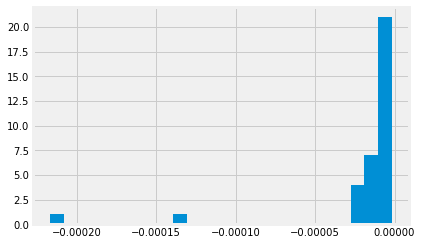


For Vehiecle:  class8_conv_2021_daycab_regionalhaul_FU19
Detected type:  conv
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Fuel Economy-km/g 

 Coeffs: a =  -0.0002861155539185973 , bv^2 =  17.839840668783808 b =  0.020214931454763073 )
 Coeffs: a =  -0.0003124294598573109 , bv^2 =  20.862605443897394 b =  0.00843487871637306 )
 Coeffs: a =  -0.0002685905223133545 , bv^2 =  21.562173706528228 b =  0.00399137241522705 )
 Coeffs: a =  -0.0002730363058676038 , bv^2 =  21.215618704001816 b =  0.004195616739710841 )
 Coeffs: a =  -0.0002201952618883709 , bv^2 =  19.371756316578463 b =  0.002821005162894132 )
 Coeffs: a =  -0.0002376356147182581 , bv^2 =  18.57581114288073 b =  0.007194738618413503 )
 Coeffs: a =  -0.0002951254994878678 , bv^2 =  20.750313958134797 b =  0.006111857420443538 )
 Coeffs: a =  -0.00024312427647326057 , bv^2 =  19.47350900934907 b =  0.005414950392691491 )
 Coeffs: a =  -0.00023902119467541944 , bv^2 =  19.966382465235508 b =  0.005215781215461219 )
 Coe

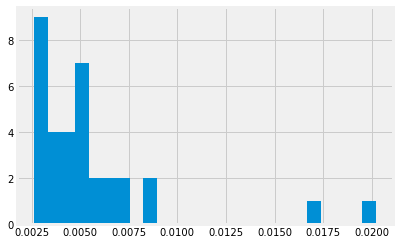


For Vehiecle:  class8_mild48v_2021_daycab_regionalhaul_FU19
Detected type:  bev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Battery Energy Consumption per Mile-kWh/km 

 Coeffs: a =  -2.4451087021510057e-07 , bv^2 =  0.045410954434391054 b =  5.0090350314672646e-05 )
 Coeffs: a =  -1.9563021375479446e-08 , bv^2 =  0.006660666729001104 b =  2.650782456994484e-06 )
 Coeffs: a =  -2.0934096583906035e-08 , bv^2 =  0.0033338366031240288 b =  6.12506157761159e-07 )
 Coeffs: a =  1.0840023932628497e-08 , bv^2 =  0.003199808916892174 b =  6.265827872671831e-07 )
 Coeffs: a =  -2.1497648542063303e-08 , bv^2 =  0.0033620991145983303 b =  4.869563605552481e-07 )
 Coeffs: a =  -1.1831773127658818e-07 , bv^2 =  0.006707013921524082 b =  2.5502479895233936e-06 )
 Coeffs: a =  -8.712042008126514e-08 , bv^2 =  0.004548527748290013 b =  1.3235243317836264e-06 )
 Coeffs: a =  -3.014523736829032e-08 , bv^2 =  0.0030469903037057145 b =  8.384113226590491e-07 )
 Coeffs: a =  -2.8871625899203263e-

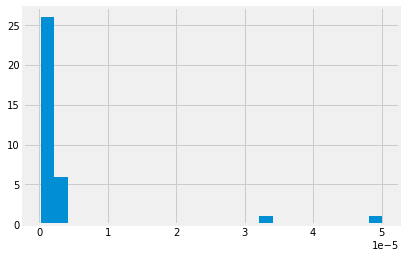


For Vehiecle:  class8_erev_2021_daycab_regionalhaul_FU19
Detected type:  bev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Battery Energy Consumption per Mile-kWh/km 

 Coeffs: a =  1.6261091081957378e-05 , bv^2 =  0.5090108096442971 b =  0.0005577440045801613 )
 Coeffs: a =  4.662898783758466e-06 , bv^2 =  0.4319604181339312 b =  0.00017138604942662335 )
 Coeffs: a =  -1.9009845582102855e-07 , bv^2 =  0.2988836773054849 b =  5.483333721772191e-05 )
 Coeffs: a =  8.672252616132616e-07 , bv^2 =  0.42474267268020716 b =  8.300812728162846e-05 )
 Coeffs: a =  -3.638836724852483e-08 , bv^2 =  0.27894437641483244 b =  4.036410947269398e-05 )
 Coeffs: a =  1.9240414331713967e-06 , bv^2 =  0.5029361514056578 b =  0.00019044476897074185 )
 Coeffs: a =  6.82835853599321e-07 , bv^2 =  0.4561479913005868 b =  0.00013239484666144227 )
 Coeffs: a =  1.3903504687325744e-07 , bv^2 =  0.24804309742088454 b =  6.802163618719422e-05 )
 Coeffs: a =  1.385306739110086e-07 , bv^2 =  0.3158319280020

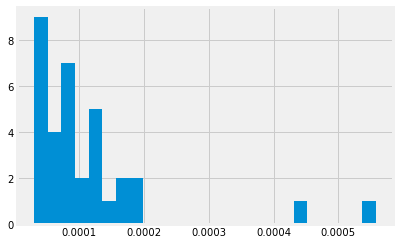


For Vehiecle:  class8_bev_2021_daycab_regionalhaul_FU19
Detected type:  bev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Battery Energy Consumption per Mile-kWh/km 

 Coeffs: a =  2.8013758714879756e-05 , bv^2 =  0.5455032912979113 b =  0.0005961400517445864 )
 Coeffs: a =  2.4096493590750996e-05 , bv^2 =  0.5466419527275196 b =  0.00021657181513348711 )
 Coeffs: a =  1.854004790413697e-05 , bv^2 =  0.6770875921693973 b =  0.000124142065773517 )
 Coeffs: a =  1.965574829947688e-05 , bv^2 =  0.6740406998783238 b =  0.00013162194832199472 )
 Coeffs: a =  1.848605071290972e-05 , bv^2 =  0.7987690470555235 b =  0.00011553370813895472 )
 Coeffs: a =  2.1193807509982745e-05 , bv^2 =  0.7377878439615939 b =  0.00027881841964346344 )
 Coeffs: a =  2.2353308623138148e-05 , bv^2 =  0.6164823287636992 b =  0.00017871511894462116 )
 Coeffs: a =  1.9673286818534075e-05 , bv^2 =  0.7289643023968372 b =  0.00019968805008458937 )
 Coeffs: a =  1.846312754722174e-05 , bv^2 =  0.717396879398808

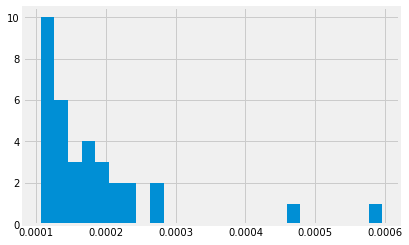


For Vehiecle:  class8_fchev_2021_daycab_regionalhaul_FU19
Detected type:  bev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  Battery Energy Consumption per Mile-kWh/km 

 Coeffs: a =  6.403142649704937e-06 , bv^2 =  -0.19620276162034764 b =  -0.0002150785301368219 )
 Coeffs: a =  1.8447763564779586e-06 , bv^2 =  -0.057706262006976206 b =  -2.290348479208609e-05 )
 Coeffs: a =  7.7204286654219e-07 , bv^2 =  -0.01930908808322669 b =  -3.5428849853184095e-06 )
 Coeffs: a =  1.578716406582524e-06 , bv^2 =  -0.04289727801332674 b =  -8.388850691989216e-06 )
 Coeffs: a =  3.4520808603227423e-07 , bv^2 =  -0.01222116931433986 b =  -1.768646805987995e-06 )
 Coeffs: a =  1.9017745143063466e-06 , bv^2 =  -0.0507718014689426 b =  -1.9247865179640784e-05 )
 Coeffs: a =  1.6284356332686775e-06 , bv^2 =  -0.043334092801640564 b =  -1.2577040499385489e-05 )
 Coeffs: a =  6.612271890191191e-07 , bv^2 =  -0.02047443637803031 b =  -5.623179133141411e-06 )
 Coeffs: a =  4.344987433646675e-07 , bv^

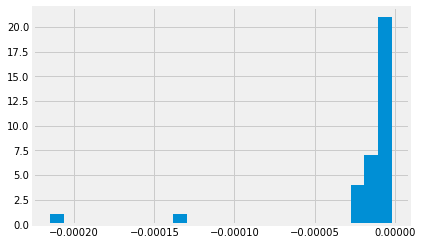

In [31]:
%matplotlib inline
dataSourcePath = '0623_hetero\\Batch_Div27_Rep_Day_Class_8_Compiled_Results_metrics.xlsx'
generateData(dataSourcePath, saveFolderName = "OLS_Data")

In [5]:
a = [1,2,3]
np.append(a, 5)

array([1, 2, 3, 5])

# Function: readData
 ### Reads the source folder generated by the  "generateData" function returns a, b, as dictionaries.
> Input:  
(str) saveFolderName: Name of source folder created by generateData
  
Output: 
>a [ k ][ i ][ j ]  
b [ k ][ i ][ j ] 


> (str) k : Vehiecle Type       
(int) i : i-node , index starts from 1  
(int) j : j-node , index starts from 1  

## Note:  -1 is a dummy value (for self-loops and array padding)

In [6]:
# Reads out the data and collects them into a dictionary.
def readDataCSV (saveFolderName = "OLS_Data"):
    
    # Initialize some folderpath
    path = os.path.join(os.getcwd(), saveFolderName)
    
    # If the folder doesn't exist, print error and return
    if not os.path.exists(path):
        print("Error, Source Folder Doesn't exist")
        return 
    VehiecleTypesPath = [ fi for fi in os.listdir(path) if fi.endswith(".pkl") ]
    VehiecleTypes = [i[:len(i) - 4] for i in VehiecleTypesPath] # change to use split or something else
    
    # Get the number of nodes brute forcedly
    filePath = os.path.join(path, VehiecleTypesPath[0])
    df = pd.read_pickle(filePath)
    numNodes = np.shape(df.iloc[:, 0].values)[0]
    
    # Initializing return dictionary
    a = {}
    b = {}

    for ind, v in enumerate(VehiecleTypes):
        filePath = os.path.join(path, v + ".pkl")
        df = pd.read_pickle(filePath)
        
        # initialize an empty array to store the days
        a[v] = np.full((numNodes + 1, numNodes + 1), -1, dtype = float)
        b[v] = np.full((numNodes + 1, numNodes + 1), -1, dtype = float)
        
        results = df.to_numpy().transpose()
        for i, temp in enumerate(results, 1):
            for j, ab in enumerate(temp, 1):
                if type(ab) == tuple:
                    a[v][i][j], b[v][i][j] = ab[0], ab[1] 
                else:
                    a[v][i][j], b[v][i][j] = ab, ab
                    
    return a, b

In [7]:
a, b = readDataCSV()

In [8]:
# Example lookup
k = 'class8_conv_2021_daycab_regionalhaul_FU19'
i = 73
j = 1

a[k][i][j], b[k][i][j] 

IndexError: index 73 is out of bounds for axis 0 with size 19

# 3D Plots

In [13]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Building Model
from sklearn import linear_model
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib tk

# warnings.filterwarnings('ignore')
# plt.rcParams['figure.figsize'] = (7, 7)
# plt.style.use('ggplot')

In [14]:
def square(x):
    return x*x

################## Params #########################
dataSourcePath = '0623_hetero\\Batch_Div27_Rep_Day_Class_8_Compiled_Results_metrics.xlsx'
# dataSourcePath = 'old_data//Batch_Div27_2021_03_months_Conv_BE_RH_Base_Edges_Crr_Std_Results_metrics.xlsx'

In [15]:
# Loading Dataset
df_trucks = pd.read_excel(os.path.join(os.getcwd(), dataSourcePath), \
#                    sheet_name = "DOE",\
                   index_col=None, \
                   usecols=['Vehicle Model-none',\
                      'Fuel Consumption per 100 miles-Diesel Equiv. gal/100mi',\
                      'Battery Energy Consumption per Mile-kWh/mi',\
                      'Average Total Speed-mph',\
                      'Vehicle Static Mass-lbm']
                  )
# Data conversion
df_trucks['Vehicle Static Mass-lbm'] = df_trucks['Vehicle Static Mass-lbm']*0.453592
df_trucks.rename(columns = {'Vehicle Static Mass-lbm':'StaticMass-kg'}, inplace = True)
df_trucks['Average Total Speed-mph'] = (df_trucks['Average Total Speed-mph']*1.60934).apply(square)
df_trucks.rename(columns = {'Average Total Speed-mph':'SpeedSquared-(kmph)^2'}, inplace = True)

df_trucks['Fuel Consumption per 100 miles-Diesel Equiv. gal/100mi'] = df_trucks['Fuel Consumption per 100 miles-Diesel Equiv. gal/100mi']/160.934
df_trucks.rename(columns = {'Fuel Consumption per 100 miles-Diesel Equiv. gal/100mi':'FuelEconomy-gal/km'}, inplace = True)
df_trucks['Battery Energy Consumption per Mile-kWh/mi'] = df_trucks['Battery Energy Consumption per Mile-kWh/mi']/1.60934
df_trucks.rename(columns = {'Battery Energy Consumption per Mile-kWh/mi':'BatteryCost-kWh/km'}, inplace = True)

In [17]:
conv = df_trucks[df_trucks['Vehicle Model-none'] == 'class8_conv_2021_daycab_regionalhaul_FU19']
bev = df_trucks[df_trucks['Vehicle Model-none'] == 'class8_bev_2021_daycab_regionalhaul_FU19']

In [18]:
# Dropping unused columns
conv = conv.drop(['Vehicle Model-none', 'BatteryCost-kWh/km'], axis = 1)
bev = bev.drop(['Vehicle Model-none', 'FuelEconomy-gal/km'], axis = 1)

In [19]:
################## Params #########################
data = conv
energy = 'FuelEconomy-gal/km'
data

,StaticMass-kg,FuelEconomy-gal/km,SpeedSquared-(kmph)^2
3264,9071.840,0.052641,5370.721155
3265,9071.840,0.050246,5370.891963
3266,14514.944,0.059419,5371.401310
3267,14514.944,0.055612,5371.475417
3268,19958.048,0.066641,5369.802229
...,...,...,...
3667,25401.152,0.072676,6993.531902
3668,30844.256,0.086405,6964.883647
3669,30844.256,0.078554,6972.044299
3670,36287.360,0.093691,6927.716328


In [20]:
# Testing visualization
sns.set_palette('colorblind')
sns.pairplot(data=data, kind = 'reg', height=3, plot_kws = {'scatter_kws' : {'color': 'gray'}                                                     })

In [22]:
# Set independent and dependent variables
X = data[['StaticMass-kg', 'SpeedSquared-(kmph)^2']]
y = data[energy]

# Initialize model from sklearn and fit it into our data
regr = linear_model.LinearRegression()
model = regr.fit(X, y)
    
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

Intercept: 0.051685538978357676
Coefficients: [ 1.32104113e-06 -1.82180918e-06]


In [21]:
# # Values to predict
# vehicleMass = input('What is the Vehicle Mass? \n')
# avgSpeed = input('What is the average speed? \n')

# try:
#     print('We predict {:.0f} pies will be sold if we sold the pie at ${} and spend ${} at advertising.'.format(
#         model.predict([[float(vehicleMass), float(avgSpeed)]])[0],
#         vehicleMass, 
#         avgSpeed))
# except ValueError:
#     print('Please only input either:\n- whole number e.g. 1, 4, 7\n- decimal/float number e.g. 3.8')


In [23]:
# Prepare data
X = data[['StaticMass-kg', 'SpeedSquared-(kmph)^2']].values.reshape(-1,2)
Y = data[energy]

# Create range for each dimension
x = X[:, 0]
y = X[:, 1]
z = Y

xx_pred = np.linspace(9000, 37000, 30)  # range of mass values
yy_pred = np.linspace(0, 9000, 30)  # range of speed values
xx_pred, yy_pred = np.meshgrid(xx_pred, yy_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# Predict using model built on previous step
# ols = linear_model.LinearRegression()
# model = ols.fit(X, Y)
predicted = model.predict(model_viz)

# Evaluate model by using it's R^2 score 
r2 = model.score(X, Y)

# Plot model visualization
plt.style.use('fivethirtyeight')

# fig = plt.figure(figsize=(12, 4))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlabel('StaticMass-kg', fontsize=12)
ax1.set_ylabel('AvgSpeed^2-(km/h)^2', fontsize=12)
ax1.set_zlabel(energy, fontsize=12)
ax1.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
ax1.scatter(x, y, z, color='k', alpha=0.5)
fig.suptitle('class8_conv_2021_daycab_regionalhaul_FU19 Cost Visualization ($R^2 = %.2f$)' % r2, fontsize=15, color='k')

plt.show()
# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
# ax3 = fig.add_subplot(133, projection='3d')
# axes = [ax1, ax2, ax3]

# for ax in axes:
#     ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
#     ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
#     ax.set_xlabel('VehicleStaticMass (kg)', fontsize=12)
#     ax.set_ylabel('AverageSpeed (kmph)', fontsize=12)
#     ax.set_zlabel('Fuel Per km (gal/km)', fontsize=12)
#     ax.locator_params(nbins=4, axis='x')
#     ax.locator_params(nbins=5, axis='x')

# ax1.view_init(elev=25, azim=-60)
# ax2.view_init(elev=15, azim=15)
# ax3.view_init(elev=25, azim=60)

# fig.suptitle('Multi-Linear Regression Model Visualization ($R^2 = %.2f$)' % r2, fontsize=15, color='k')

# fig.tight_layout()